In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time 
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn import svm, datasets
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPool1D, Dropout, Activation, Input, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.models import Sequential
from keras.initializers import Constant

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
df_original = pd.read_csv('/content/gdrive/My Drive/DataSet/tweet_emotions.csv', encoding='windows-1252')

In [4]:
df = df_original.copy()

In [5]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [6]:
df.count()

tweet_id     40000
sentiment    40000
content      40000
dtype: int64

In [7]:
df.head(5)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [8]:
df = df.loc[:,['sentiment','content']]

In [9]:
df.head(2)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...


In [10]:
df['sentiment'] = df['sentiment'].str.lower()

In [11]:
df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [12]:
df.shape

(40000, 2)

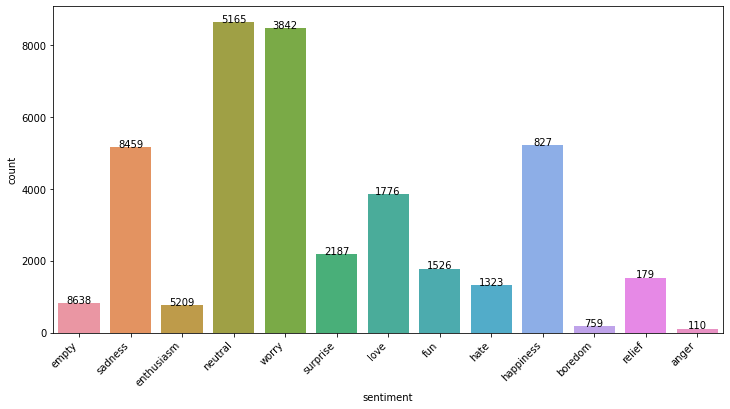

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax = sns.countplot(x='sentiment', data=df)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height + 0.1, df['sentiment'].value_counts()[i], ha='center')
    i+=1

In [14]:
#removing class if any has a value 1
df = df.groupby('sentiment').filter(lambda x : len(x)>1)

#removing stopwords
stop = stopwords.words('english')
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removing urls
df['content'] = df['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#removing HTML Tags
def remove_tags(string):
    result = re.sub('<.*?>', '', string)
    return result
df['content'] = df['content'].apply(lambda cw : remove_tags(cw))

#removing '\n' in the code
df['content'] = df['content'].replace('\n', ' ', regex=True)

#removing punctuations
punctuation = '''!()-[]{};:'"\,<>/?@#$%^&*~'''
def remove_punctuations(text):
    for punc in punctuation:
        text = text.replace(punc, '')
    return text
df['content'] = df['content'].apply(remove_punctuations)

#removing digits
df['content'] = df['content'].str.replace('\d+', '')

In [15]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed headache ughhhh...waitin call...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants hang friends SOON
4,neutral,dannycastillo We want trade someone Houston ti...


In [16]:
#lemmitization
# from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize

WNlemma = nltk.WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def pre_process_with_pos_tag(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if len(t)>2]
    tokens = [WNlemma.lemmatize(t, get_wordnet_pos(pos_tag(word_tokenize(t))[0][1])) for t in tokens]
    text_after_process = " ".join(tokens)
    return text_after_process

In [17]:
df['content'] = df['content'].apply(pre_process_with_pos_tag)

In [18]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin bed headache ughhhh ... waitin call ...
2,sadness,funeral ceremony ... gloomy friday ...
3,enthusiasm,want hang friend soon
4,neutral,dannycastillo want trade someone houston ticke...


In [19]:
#Analysing the words in the content column
results = set()
df['content'].str.lower().str.split().apply(results.update)
print(results)

{'sx.com', 'makikaysantos', 'maven', 'sugar', 'everrrr', 'travisricejr', 'wld', 'httpshort.tocevd', 'zimmermannillionaredhini', 'danwtmoon', 'reborn', 'carol', 'lula', '.quotbreakfastquot', 'suzydafloozy', 'wale', 'shadduppp', 'irk', 'summery', 'sinon', 'nessepes', 'godaddy', 'mattwerkmeister', '..be', 'vcha', 'httpbit.lyrrfc', 'sarinnejonas', 'abbreviation', 'jailbroken', '.if', 'geoffjones', 'iloveicetea', 'jayceiinc', 'khaled', 'evlover', 'twitmama', 'abacab', 'lilstrobe', 'cnaterbury', 'tvxquknow', 'know', 'mamalou', 'brd', 'joyknows', 'kge', 'bortron', 'ftw', 'rinse', 'httpmyloc.mezx', 'jovi', 'quesadiaas', 'melissaohh', 'vickybonnett', 'kathyireland', 'ntah', 'pdoc', 'mosquito..it', 'pjs', 'matternal', 'lately', 'ladyhaych', 'yellowflowers', 'complete', 'myinkyfingersau', 'pazkallah', 'gromit', 'httpplurk.compsvhvh', 'kellykleinwi', 'vonnieee', 'httptwitpic.comxs', 'opener', 'oopsgtlt', 'mamo', 'fobchick', 'lillytown', 'russelldevon', 'zaneology', 'friday..', 'fma', 'standby', 'h

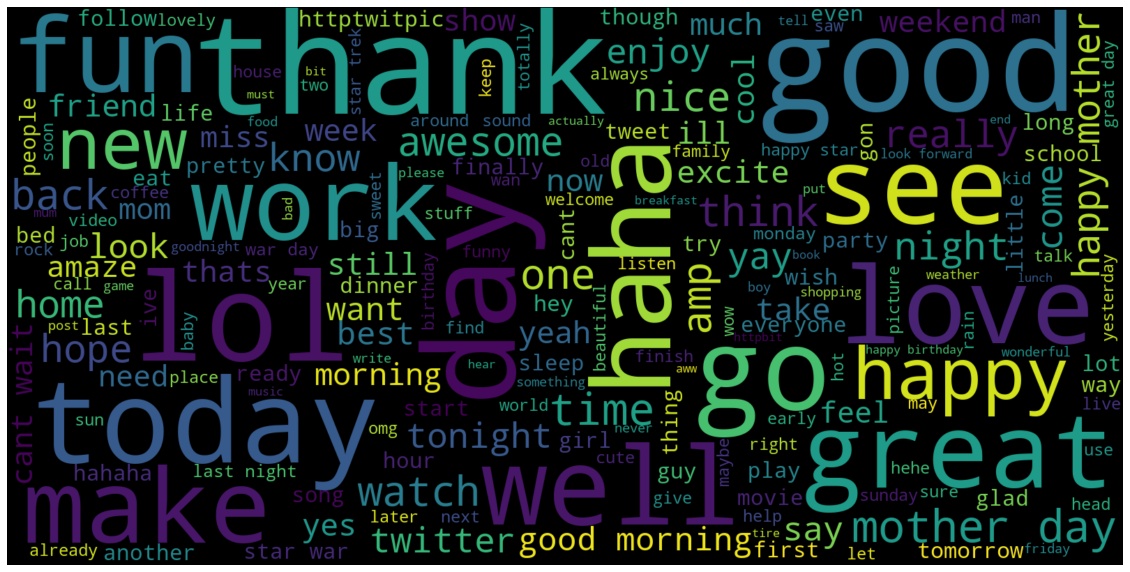

In [20]:
#wordcloud
class_label_0 = df[df['sentiment'] =='happiness']
string_0 = []
for t in class_label_0.content:
    string_0.append(t)
string_0 = pd.Series(string_0).str.cat(sep=' ')
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(string_0)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
x_all = df['content']
y_all = df['sentiment']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, stratify=y_all, test_size=0.25, random_state=42)

In [23]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [24]:
le = preprocessing.LabelEncoder()
yy_train = le.fit_transform(y_train)

In [25]:
le1 = preprocessing.LabelEncoder()
yy_test = le1.fit_transform(y_test)

In [26]:
max_words = 10000
max_len = 100
tok1 = Tokenizer(num_words=max_words)
tok1.fit_on_texts(x_train.values)
sequences = tok1.texts_to_sequences(x_train.values)
word_index = tok1.word_index
print('Found %s unique tokens train.' % len(word_index))
data_x_train = pad_sequences(sequences, maxlen=max_len)
print(data_x_train.shape)

tok_test = Tokenizer(num_words=max_words)
tok_test.fit_on_texts(x_test.values)
sequences_test = tok_test.texts_to_sequences(x_test.values)
word_index_test = tok_test.word_index
print('Found %s unique tokens test.' % len(word_index_test))
sequences_matrix_test = pad_sequences(sequences_test, maxlen=max_len)

Found 36250 unique tokens train.
(30000, 100)
Found 16539 unique tokens test.


In [27]:
num_words = min(max_words, len(word_index)) + 1

In [31]:
#load embedding into memory
embeddings_index = dict()
# loading own embedding
f = open('/content/gdrive/My Drive/DataSet/custom_embedding_100d.txt', encoding='utf8')
for line in f:
  values = line.split(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Custom Enbedding data loaded')

Custom Enbedding data loaded


In [35]:
embedding_dim = 100
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
  if i > max_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]  = embedding_vector

embedding_layer = Embedding(num_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False)

In [36]:
model = Sequential()
model.add(Embedding(num_words, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(LSTM(300))
model.add(Dense(df.sentiment.nunique(), activation='relu'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000100   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 300)               438000    
                                                                 
 dense (Dense)               (None, 13)                3913      
                                                      

In [37]:
start_time= time.time()
history = model.fit(data_x_train, yy_train, epochs=10, batch_size=256, validation_split=0.2, verbose=1)
print("___ %s seconds ---" % (time.time() - start_time))

Epoch 1/10
94/94 [==============================] - 15s 41ms/step - loss: 3.6338 - accuracy: 0.2250 - val_loss: 3.5288 - val_accuracy: 0.2595
Epoch 2/10
94/94 [==============================] - 3s 29ms/step - loss: 3.5173 - accuracy: 0.2337 - val_loss: 3.5135 - val_accuracy: 0.2608
Epoch 3/10
94/94 [==============================] - 3s 28ms/step - loss: 3.4485 - accuracy: 0.2557 - val_loss: 3.5194 - val_accuracy: 0.2757
Epoch 4/10
94/94 [==============================] - 3s 29ms/step - loss: 3.4073 - accuracy: 0.2649 - val_loss: 3.4401 - val_accuracy: 0.2752
Epoch 5/10
94/94 [==============================] - 3s 29ms/step - loss: 2.5574 - accuracy: 0.2587 - val_loss: 2.1789 - val_accuracy: 0.2825
Epoch 6/10
94/94 [==============================] - 3s 29ms/step - loss: 2.1683 - accuracy: 0.2678 - val_loss: 2.1276 - val_accuracy: 0.2877
Epoch 7/10
94/94 [==============================] - 3s 29ms/step - loss: 2.2326 - accuracy: 0.2541 - val_loss: 2.2271 - val_accuracy: 0.2670
Epoch 8/10
9

In [38]:
print("accuracy of training data is - ", model.evaluate(data_x_train, yy_train)[1]*100, "%")
print("accuracy of testing data is - ", model.evaluate(sequences_matrix_test, yy_test)[1]*100, "%")

938/938 [==============================] - 5s 6ms/step - loss: 2.1369 - accuracy: 0.2992
accuracy of training data is -  29.916667938232422 %
313/313 [==============================] - 2s 7ms/step - loss: 2.2812 - accuracy: 0.2403
accuracy of testing data is -  24.02999997138977 %


In [39]:
y_pred = model.predict(sequences_matrix_test)

In [40]:
y_classes = y_pred.argmax(axis=-1)

In [41]:
y_classes

array([12,  8,  5, ...,  5,  8,  8])

In [42]:
yy_test

array([ 8,  9, 12, ...,  4,  5, 10])

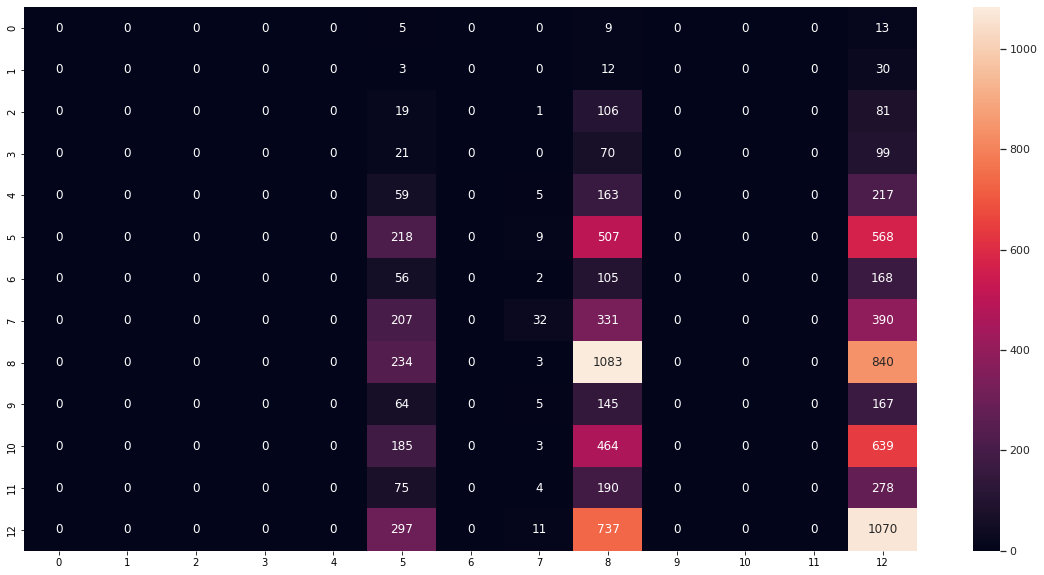

In [43]:
cf_matrix = confusion_matrix(yy_test, y_classes)
fig, ax = plt.subplots(figsize=(20,10))
sns.set(rc={'figure.figsize':(7,4)})
sns.heatmap(cf_matrix, annot=True, fmt='g')